# Classification: Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model (which is based on the network architecture of Krizhevsky et al. for ImageNet).

We'll compare CPU and GPU modes and then dig into the model to inspect features and the output.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# for store the results
from six.moves import cPickle as pickle
import gzip

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import os
caffe_root = '/opt/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

- To avoid truncated images problem

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### 2. Load net and set up input preprocessing

* Set Caffe to GPU mode (Tesla) and load the net from disk.

In [4]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
#caffe.set_mode_cpu()

In [5]:
model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [6]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

In [7]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

### 3. Extract the features

* Now we're ready to perform classification. First we create an array with the files of the images.

* This function extracts decaf features in batches of a list of images

In [ ]:
def extract_decaf_features(images_root,list_images,layer,net,transformer):
    # set the size of the input (we can skip this if we're happy
    # with the default; we can also change it later, e.g., for different batch sizes)
    batch, C, H, W = net.blobs['data'].shape
    
    num_images = len(list_images)
    
    output_shape = net.blobs[layer].shape
    output_shape[0] = num_images
    output = np.zeros(output_shape)
    
    count = 0
    while count < num_images:
        pre_count = count    
        for i in range(0,batch):
            if count >= num_images:
                i -= 1
                break
            try:
                image = caffe.io.load_image(images_root + list_images[count])
                if len(image.shape)>3:
                    image = image[0]
                transformed_image = transformer.preprocess('data', image)
                net.blobs['data'].data[i] = transformed_image
            except:
                print (count)
                raise
            count += 1
        
        net.forward()
    
        output[pre_count:count]=net.blobs[layer].data[0:i+1]
    
    return output

In [7]:
images_root = '/home/frubio/AVA/AVADataset/'
list_images = os.listdir(images_root)
list_images.sort()

In [ ]:
decaf_features = extract_decaf_features(images_root,list_images[0:10],'fc6',net,transformer)

In [ ]:
pickle.dump(decaf_features, gzip.open("aux_feat.pklz","wb" ), 2)

In [ ]:
aux_feat = pickle.load(gzip.open('aux_feat.pklz','rb',2))

* Finally, we call the function

In [ ]:
divisions = 100
batch_images = len(list_images)/divisions
batch_images_rest = len(list_images)%divisions

prev_images = 0
post_images = batch_images

for i in range(0,divisions):
    decaf_features = extract_decaf_features(images_root,list_images[prev_images:post_images],'pool5',net,transformer)
    pickle.dump(decaf_features, gzip.open( "pool5_caffenet/pool5_caffenet_%02d.pklz" % i, "wb" ), 2)
    
    decaf_features = extract_decaf_features(images_root,list_images[prev_images:post_images],'fc6',net,transformer)
    pickle.dump(decaf_features, gzip.open( "fc6_caffenet/fc6_caffenet_%02d.pklz" % i, "wb" ), 2)
    
    decaf_features = extract_decaf_features(images_root,list_images[prev_images:post_images],'fc7',net,transformer)
    pickle.dump(decaf_features, gzip.open( "fc7_caffenet/fc7_caffenet_%02d.pklz" % i, "wb" ), 2)
    
    prev_images += batch_images
    post_images += batch_images
    if post_images > len(list_images):
        post_images = len(list_images)
        
decaf_features = extract_decaf_features(images_root,list_images[prev_images:len(list_images)],'fc7',net,transformer)
pickle.dump(decaf_features, gzip.open( "fc7_caffenet/fc7_caffenet_%02d.pklz" % i, "wb" ), 2)

In [ ]:
model_def = caffe_root + 'models/ResNet-152/ResNet-152-deploy.prototxt'
model_weights = caffe_root + 'models/ResNet-152/ResNet-152-model.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [ ]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [ ]:
divisions = 100
batch_images = len(list_images)/divisions

prev_images = 0
post_images = batch_images

for i in range(0,divisions):
    decaf_features = extract_decaf_features(images_root,list_images[prev_images:post_images],'pool5',net,transformer)
    pickle.dump(decaf_features, gzip.open( "pool5_ResNet-152/pool5_ResNet-152_%02d.pklz" % i, "wb" ), 2)
    
    prev_images += batch_images
    post_images += batch_images
    if post_images > len(list_images):
        post_images = len(list_images)

### 4. Adding the index to the features packages

In [4]:
from shutil import copyfile

In [10]:
features_file = '../features/AesNet_CaffeNet_fc7.pklz'

In [11]:
index_images = [int(i[0:-4]) for i in list_images]
features = pd.DataFrame( pickle.load(open(features_file,'rb')))
features['id']= index_images
pickle.dump(features,  open("../features/aux_file.pklz", 'wb'), pickle.HIGHEST_PROTOCOL)

In [12]:
copyfile("../features/aux_file.pklz", features_file)
os.remove("../features/aux_file.pklz")

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

probabilities and labels:
[(0.13447513,), (0.13275301,), (0.077446699,), (0.066684894,), (0.059878424,)]


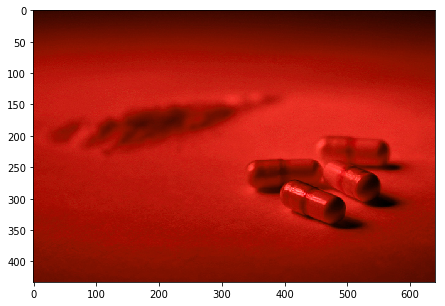

In [16]:
# download an image
#my_image_url = "..."  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
#!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image(images_root+'10010.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print ('probabilities and labels:')
print(list(zip(output_prob[top_inds])))

In [22]:
net.blobs['prob'].data[...]

array([[  7.00174098e-07,   6.05163659e-05,   1.69479154e-05, ...,
          4.81372035e-06,   1.74216905e-06,   1.18035292e-04],
       [  7.00174098e-07,   6.05163659e-05,   1.69479154e-05, ...,
          4.81372035e-06,   1.74216905e-06,   1.18035292e-04],
       [  7.00174098e-07,   6.05163659e-05,   1.69479154e-05, ...,
          4.81372035e-06,   1.74216905e-06,   1.18035292e-04],
       ..., 
       [  7.00174098e-07,   6.05163659e-05,   1.69479154e-05, ...,
          4.81372035e-06,   1.74216905e-06,   1.18035292e-04],
       [  7.00174098e-07,   6.05163659e-05,   1.69479154e-05, ...,
          4.81372035e-06,   1.74216905e-06,   1.18035292e-04],
       [  7.00174098e-07,   6.05163659e-05,   1.69479154e-05, ...,
          4.81372035e-06,   1.74216905e-06,   1.18035292e-04]], dtype=float32)

In [ ]:
feat = net.blobs['fc8'].data[0]
plt.figure(figsize=(10,5))
plt.plot(feat.flat)

In [23]:
# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

In [24]:
output_prob

array([  7.00174098e-07,   6.05163659e-05,   1.69479154e-05,
         1.31385923e-05,   1.09308879e-04,   2.15949331e-06,
         9.97960706e-06,   7.18719184e-06,   9.28534121e-07,
         2.05342894e-06,   1.06348477e-06,   6.23669564e-07,
         1.46724938e-06,   1.44300930e-06,   3.19512537e-07,
         1.11140298e-06,   1.93037249e-06,   2.60058044e-07,
         5.58510806e-07,   7.83145140e-07,   3.34085348e-06,
         1.36467452e-06,   1.08688619e-06,   9.63587809e-06,
         9.74306644e-08,   1.08865381e-04,   1.27401494e-04,
         1.88351143e-03,   6.51651120e-04,   4.35427246e-05,
         5.05339312e-06,   8.98255093e-04,   1.71441119e-03,
         2.11182469e-05,   3.97764787e-04,   6.47110141e-07,
         2.58619384e-05,   2.92013124e-06,   1.01006684e-04,
         2.43755039e-07,   3.93943010e-05,   5.86035594e-06,
         3.16033970e-06,   4.36115840e-07,   1.24542903e-05,
         1.41077699e-05,   2.09777572e-05,   2.15696991e-06,
         1.09373934e-06,